In [1]:
from typing import Iterable
import pandas as pd
from IPython.core.display import display
from sklearn.metrics import label_ranking_average_precision_score, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def getRawData():
    bug_report_raw=pd.read_pickle("Output/allBugReports.pickle")
    bug_report_raw = bug_report_raw[bug_report_raw['description'].notna()].reset_index()
    display(bug_report_raw)

    source_code_raw = pd.read_pickle("Output/allSourceCodes.pickle")
    source_code_raw = source_code_raw[source_code_raw['unprocessed_code'].notna()]
    display(source_code_raw)
    return bug_report_raw, source_code_raw

In [2]:
def filterBugReportsMissingFiles(bug_report_raw, source_code_raw):
    source_file_names_dot_format=set(source_code_raw["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\",".")).tolist())

    # create copy of bug report dataframe
    filter_missing_files = bug_report_raw.copy()

    # return the filenames that appear in the source code dataframe only
    for index, row in filter_missing_files.iterrows():
        filter_missing_files.at[index, "fix"] = list(set(row['fix']).intersection(source_file_names_dot_format))

    # filter out empty arrays
    filter_missing_files = filter_missing_files[filter_missing_files.fix.str.len()>0]
    return filter_missing_files

## Cleaning the Data

Snowball Stemmer is used since it is a more powerful stemmer than what is used by the research paper on IRFL.
  
In addition to NLTK's stop words, Python and Java keywords have been removed to provide a better model for analysis. The Python keywords will come from a built-in library called "keyword", while Java language keywords will be extracted from a file provided by the original GitHub source found here: https://github.com/exatoa/Bench4BL/blob/master/scripts/languages.txt

Camel case words such as setValue will be split into two words, "set" and "Value".

All letters will be turned into lowercases so there would not be any distinction between "Value" and "value", for example.

In [3]:
import re, string
import pandas as pd
import numpy as np
import keyword
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
import html

%matplotlib inline

stemmer = SnowballStemmer("english")

java_keywords = None
with open('languages.txt', 'r') as file:
    java_keywords = file.read().split('\n')

# set for o(1) lookup performance
stop_words = set(list(ENGLISH_STOP_WORDS) + keyword.kwlist + java_keywords)

def clean_text(text):
    # This is to remove the double html encodings such as &amp;apos; into simply &apos;.
    # This html encoding is easier to convert into punctuation or special characters for removal.
    text = text.replace("&amp;", '&')
    text = html.unescape(text)

    # split words and return them if it is not in the stop words list
    def getIndividualWords(all_text:str) ->Iterable[str]:
        # this regex splits apart camel case variables.
        # first half of | handles cases which are traditionally camel cased, or are just lower case.
        # second half of | handles cases where its all capital letters, ie a variable named VARIABLE
        # this also implicitly gets rid of any punctuation and any whitespace. This is because the regex
        # skips over any non-letter characters
        for word in re.findall('[A-Z]*[a-z]+|[A-Z]{2,}', all_text):
            word_lower=word.lower()
            if word_lower not in stop_words:
                yield stemmer.stem(word_lower)

    text=' '.join(getIndividualWords(text))
    return text

# print("Before:\n", bug_report_raw["description"][0])
# print("\n\nAfter:\n", clean_text(bug_report_raw["description"][0]))

In [4]:
def getProcessedData():
    bug_report_raw,source_code_raw=getRawData()
    filter_missing_files=filterBugReportsMissingFiles(bug_report_raw,source_code_raw)
    filter_missing_files["processed_description"]=filter_missing_files["description"].map(clean_text)
    filter_missing_files["processed_summary"]=filter_missing_files["summary"].map(clean_text)
    filter_missing_files["processed_all"]=filter_missing_files["processed_description"] + filter_missing_files["processed_summary"]
    filter_missing_files=filter_missing_files[["fix","processed_all","project"]]
    display(filter_missing_files)
    source_code_raw["processed_code"]=source_code_raw["unprocessed_code"].map(clean_text)
    source_code_raw=source_code_raw[["filename","processed_code","project"]]
    display(source_code_raw)
    return filter_missing_files, source_code_raw

processed_bug_report,processed_source_code=getProcessedData()

,id,fix,text,fixdate,summary,description,project,average_precision
0,217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
1,214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
2,222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
3,261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
4,264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0
...,...,...,...,...,...,...,...,...
1785,692,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:35:48,Add tests for special chars in LegacyPropertie...,Add tests for issue https://issues.jboss.org/b...,ELY,0.0
1786,691,[org.wildfly.security.auth.realm.legacypropert...,NaN,2016-11-02 09:36:13,Elytron properties-realm is not compatible wit...,When users properties file (e.g. mgmt-users.pr...,ELY,0.0
1787,637,[org.wildfly.security.auth.server.serverauthen...,NaN,2016-11-03 15:03:29,No log messages comming from Elytron - permiss...,Elytron is missing any log messages related to...,ELY,0.0
1788,757,[org.wildfly.security.ssl.sslauthenticationtes...,NaN,2016-11-21 09:24:47,Don&apos;t use String toUpperCase/toLowerCase ...,The String.toUpperCase() and String.toLowerCas...,ELY,0.0


,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
...,...,...,...
63,\gitrepo\src\main\java\org\wildfly\security\ut...,"/*\n * JBoss, Home of Professional Open Source...",ELY
64,\gitrepo\src\main\java\org\wildfly\security\_p...,"/*\n * JBoss, Home of Professional Open Source...",ELY
65,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY
66,\gitrepo\src\test\java\org\wildfly\security\ma...,"/*\n * JBoss, Home of Professional Open Source...",ELY


,fix,processed_all,project
0,[org.apache.commons.collections.map.testflat3m...,flat map s entri object overwrit entri s valu ...,COLLECTIONS
1,[org.apache.commons.collections.extendedproper...,field includ extend properti current instanc s...,COLLECTIONS
2,[org.apache.commons.collections.testlistutils....,remov collect collect collect remov method cal...,COLLECTIONS
3,[org.apache.commons.collections.map.testflat3m...,flat map m flat map m integ integ m integ inte...,COLLECTIONS
4,[org.apache.commons.collections.fasttreemap.java],line current releas replac map tree map map tr...,COLLECTIONS
...,...,...,...
1770,[org.wildfly.security.manager.wildflysecuritym...,infinit loop elytron permiss collect read reso...,ELY
1771,[org.wildfly.security.ssl.ciphersuiteselector....,cipher suit avail handshak https undertow list...,ELY
1783,[org.wildfly.security._private.elytronmessages...,elytron miss log messag relat group assign log...,ELY
1784,[org.wildfly.security.ssl.protocol.java],protocol type list descript enabl protocol exp...,ELY


,filename,processed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,licens apach softwar foundat asf contributor l...,COLLECTIONS
...,...,...,...
63,\gitrepo\src\main\java\org\wildfly\security\ut...,jboss home profession open sourc copyright red...,ELY
64,\gitrepo\src\main\java\org\wildfly\security\_p...,jboss home profession open sourc copyright red...,ELY
65,\gitrepo\src\test\java\org\wildfly\security\ma...,jboss home profession open sourc copyright red...,ELY
66,\gitrepo\src\test\java\org\wildfly\security\ma...,jboss home profession open sourc copyright red...,ELY


In [5]:
from scipy.sparse import lil_matrix

def getLabelsForBugReport()->np.ndarray:
    source_file_names_dot_format=processed_source_code["filename"].map(lambda fname:"org"+fname.partition("org")[2].replace("\\","."))

    fileToIndex={}
    for idx,value in enumerate(source_file_names_dot_format.values):
        fileToIndex[value]=idx
    num_files=len(source_file_names_dot_format)
    num_bug_reports=len(processed_bug_report["fix"])
    matrix=lil_matrix((num_bug_reports,num_files))
    for idx,file_names in enumerate(processed_bug_report["fix"]):
        for file_name in list(file_names):
            try:
                matrix[idx,fileToIndex[file_name]]=1
            except KeyError:
                # note, there are many files which were 'fixes' in bug reports, but where not in the tar files given on d2l.
                # we would assume then that the tar files posted on d2l were probably missing some source files (our theory
                # is the source code is from an older version of the software)
                pass
    return matrix.toarray()



labels=getLabelsForBugReport()
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
xtrain, xtest = None, None
def method1():
    method1_vectorizer=TfidfVectorizer(lowercase=True,)
    method1_code_vector=method1_vectorizer.fit_transform(processed_source_code["processed_code"].to_numpy())
    query_vector=method1_vectorizer.transform(processed_bug_report["processed_all"].to_numpy())
    xtrain = method1_code_vector
    xtest = query_vector
    display(method1_code_vector)
    display(query_vector)
    result = cosine_similarity(query_vector,method1_code_vector)
    return result

similarities=method1()
similarities

<10461x11984 sparse matrix of type '<class 'numpy.float64'>'
	with 910922 stored elements in Compressed Sparse Row format>

<1402x11984 sparse matrix of type '<class 'numpy.float64'>'
	with 53861 stored elements in Compressed Sparse Row format>

array([[7.00226962e-02, 7.84133356e-02, 6.30993610e-03, ...,
        7.64040827e-02, 1.00947386e-03, 9.23715463e-03],
       [1.02292219e-02, 2.08101947e-02, 4.00015104e-03, ...,
        2.46271443e-02, 1.45008980e-03, 1.12057143e-03],
       [1.22357255e-01, 2.96698794e-01, 1.85910434e-02, ...,
        8.86713076e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.73058591e-03, 0.00000000e+00, 5.20976904e-03, ...,
        7.25050251e-04, 3.53287228e-03, 0.00000000e+00],
       [5.12872979e-03, 8.62310418e-03, 4.30117443e-03, ...,
        1.94523007e-02, 7.01197245e-03, 3.51704739e-02],
       [1.10141567e-02, 3.18678375e-04, 5.75575703e-03, ...,
        5.34586298e-03, 4.66788826e-03, 2.11818555e-04]])

In [7]:
# y_true = np.array([[0, 0, 1], [0, 1, 0]])
# y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
# label_ranking_average_precision_score(y_true, y_score)

In [8]:
def getMrrValue(denseLabels:np.ndarray, similarities:np.ndarray):
    # first, create a version of the labels which only has the maximum label value.
    similarities_with_labels=denseLabels*similarities
    max_valued_label_indexes=np.argmax(similarities_with_labels,axis=1)
    max_similar_labels=np.zeros_like(similarities_with_labels,dtype=np.byte)
    max_similar_labels[np.arange(len(similarities_with_labels)),max_valued_label_indexes]=1

    # then simply call label_ranking_average_precision_score, but only with the maximum labels.
    # this will make it equivalent to mrr, according to sklearns documentation.
    # see https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision
    return label_ranking_average_precision_score(max_similar_labels,similarities)

mrr_score_method1=getMrrValue(labels,similarities)
mrr_score_method1


0.33702405192970786

In [9]:
def getMAPValue(denseLabels:np.ndarray,similarities:np.ndarray):
    # simply call sklearns label_ranking_average_precision_score
    # while they are explained differently, and use different terminology in their explanations,
    # they are mathematically equivalent.
    return label_ranking_average_precision_score(denseLabels,similarities)


map_score_method1=getMAPValue(labels,similarities)
map_score_method1

0.24728994889504494

In [10]:

def getNDCGValue(denseLabels:np.ndarray,similarities:np.ndarray,num_considered=None):
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
    return ndcg_score(denseLabels,similarities,k=num_considered)

ndcg_score_method1=getNDCGValue(labels,similarities)
ndcg_score_method1

0.4231306498624228

In [11]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import scale
import heapq
# average is set to weighted, as each file type would have more bugs than others.
# map_score = average_precision_score(labels.todense(), similarities, average="weighted")
# map_score

def get_top_k_indices(matrix, k):
    return np.argpartition(matrix, len(matrix) - k)[-k:]

indices = [get_top_k_indices(row, 5).tolist() for row in similarities]
indices

[[204, 205, 19, 199, 408],
 [7394, 1559, 849, 4824, 3400],
 [100, 288, 98, 352, 2850],
 [6274, 276, 305, 436, 5239],
 [5079, 314, 27, 298, 299],
 [100, 98, 352, 2850, 288],
 [5077, 98, 2850, 288, 352],
 [302, 288, 6888, 33, 303],
 [444, 224, 6898, 36, 433],
 [5077, 352, 98, 2850, 288],
 [2850, 15, 98, 5077, 288],
 [355, 214, 386, 4540, 171],
 [7057, 108, 6760, 6923, 16],
 [431, 235, 6728, 234, 228],
 [232, 224, 36, 5079, 231],
 [352, 15, 98, 5077, 288],
 [4757, 4556, 24, 4694, 152],
 [312, 249, 250, 230, 138],
 [100, 5077, 288, 15, 98],
 [5638, 4935, 5079, 1974, 36],
 [64, 2085, 320, 33, 29],
 [6510, 215, 9, 2085, 261],
 [215, 2146, 2058, 261, 2085],
 [80, 339, 334, 333, 337],
 [104, 357, 288, 355, 15],
 [98, 60, 105, 2085, 106],
 [5077, 98, 2850, 352, 288],
 [5077, 2850, 352, 288, 98],
 [352, 5077, 2850, 98, 288],
 [203, 41, 6898, 247, 241],
 [204, 6734, 444, 6898, 247],
 [415, 4934, 303, 289, 33],
 [289, 216, 219, 207, 33],
 [217, 250, 118, 312, 249],
 [4096, 6728, 431, 228, 6898],
 

In [12]:
scores_to_plot=pd.DataFrame([{"number_recommendations":top_k_index,"ndcg_score":getNDCGValue(labels,similarities,top_k_index)} for top_k_index in range(5,51,5)])
scores_to_plot

,number_recommendations,ndcg_score
0,5,0.259015
1,10,0.294381
2,15,0.311474
3,20,0.325335
4,25,0.333313
5,30,0.339104
6,35,0.345128
7,40,0.349615
8,45,0.353282
9,50,0.356670


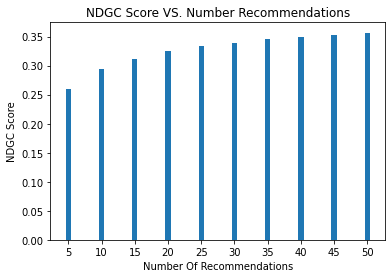

In [25]:

fig, ax = plt.subplots()
plt.bar(scores_to_plot["number_recommendations"],scores_to_plot["ndcg_score"])
plt.xticks(scores_to_plot["number_recommendations"])
plt.title("NDGC Score VS. Number Recommendations")
plt.xlabel("Number Of Recommendations")
plt.ylabel("NDGC Score")
plt.show()

In [36]:
top_values = []
top_labels = []
row = 0
for item in indices:
    top_values.append([similarities[row, col] for col in item])
    top_labels.append([labels[row, col] for col in item])
    row += 1

top_values,top_labels

([[0.5348325750854085,
   0.5432528629182195,
   0.56119334023726,
   0.5634891108305411,
   0.550527413114585],
  [0.5012904844876597,
   0.5100150724146182,
   0.52416865534854,
   0.6894250596565583,
   0.5677838622619814],
  [0.5162642904676749,
   0.5221060432409756,
   0.5415566933665473,
   0.5425305225520899,
   0.5768302822547113],
  [0.35248646418387264,
   0.3528623739899734,
   0.3586748505260377,
   0.5869638134038782,
   0.38984330293907976],
  [0.49958940419030234,
   0.5803569454878678,
   0.56277480677075,
   0.598599107607594,
   0.5072804771644365],
  [0.48120146232993305,
   0.48788295291295614,
   0.5035756752864622,
   0.5258497331535417,
   0.5188732540970227],
  [0.52312062035391,
   0.5394305313434903,
   0.5861702094586405,
   0.5645272721931864,
   0.5422387714277822],
  [0.35054740679764446,
   0.35616126025799094,
   0.3810902863400223,
   0.42702283587269685,
   0.4635723185753341],
  [0.7040402325872247,
   0.7256130644098376,
   0.7713669944026764,
   0.

In [14]:
# map_score = average_precision_score(top_labels[2], top_values[2])
# test = label_ranking_average_precision_score(np.array([top_labels[2]]), np.array([top_values[2]]))
# print(map_score)
# print(test)
#
# denseLabels=labels.todense()

# i = 0
# while i < len(top_values):

#     percision=average_precision_score(denseLabels[i], [i])
#     mrr=label_ranking_average_precision_score(denseLabels[i], m[i])


#     i += 1


In [68]:
top_values = []
top_labels = []
row = 0
for item in indices:
    top_values.append([similarities[row, col] for col in item])
    top_labels.append([labels[row, col] for col in item])
    row += 1
# print(top_values)
# print(top_labels)

top_indices_list = [5,10,15,20,25,30,35,40,45,50]

map_score_top_indices = []
mrr_score_top_indices = []
for index in top_indices_list:
    map_score_top_indices.append(getMAPValue(top_labels[:index], top_values[:index]))
    mrr_score_top_indices.append(getMrrValue(np.array(top_labels[:index]), np.array(top_values[:index])))


scores_dataFrame_Indices = pd.DataFrame({"top_k_indices":top_indices_list, "map_score_top_indices":map_score_top_indices, "mrr_sccore_top_indices":mrr_score_top_indices})
scores_dataFrame_Indices

,top_k_indices,map_score_top_indices,mrr_sccore_top_indices
0,5,0.716667,0.396667
1,10,0.683333,0.468333
2,15,0.657778,0.458889
3,20,0.680833,0.495833
4,25,0.698000,0.518000
5,30,0.731667,0.528333
6,35,0.765238,0.527143
7,40,0.762083,0.517083
8,45,0.788519,0.535185
9,50,0.786333,0.558333


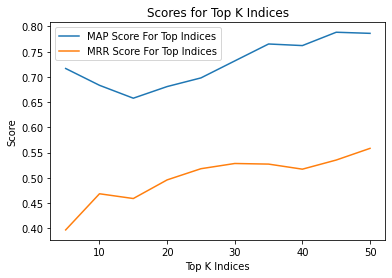

In [71]:
plt.plot(top_indices_list, map_score_top_indices, label = "MAP Score For Top Indices")
plt.plot(top_indices_list, mrr_score_top_indices, label = "MRR Score For Top Indices")
plt.xlabel('Top K Indices')
plt.ylabel('Score')
plt.title("Scores for Top K Indices")
plt.legend()
plt.show()